In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from keras.preprocessing.text import Tokenizer
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
import gensim
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument
import re
import seaborn as sns
import matplotlib.pyplot as plt

#Getting the data as dataframe

In [ ]:
df = pd.read_csv('all-data.csv',delimiter=',',encoding='latin-1')
df.head()

,neutral,"According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing ."
0,neutral,Technopolis plans to develop in stages an area...
1,negative,The international electronic industry company ...
2,positive,With the new production plant the company woul...
3,positive,According to the company 's updated strategy f...
4,positive,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...


In [ ]:
df.rename(columns={'neutral':'Sentiment','According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .':'Statement'},inplace=True)
df.columns

Index(['Sentiment', 'Statement'], dtype='object')

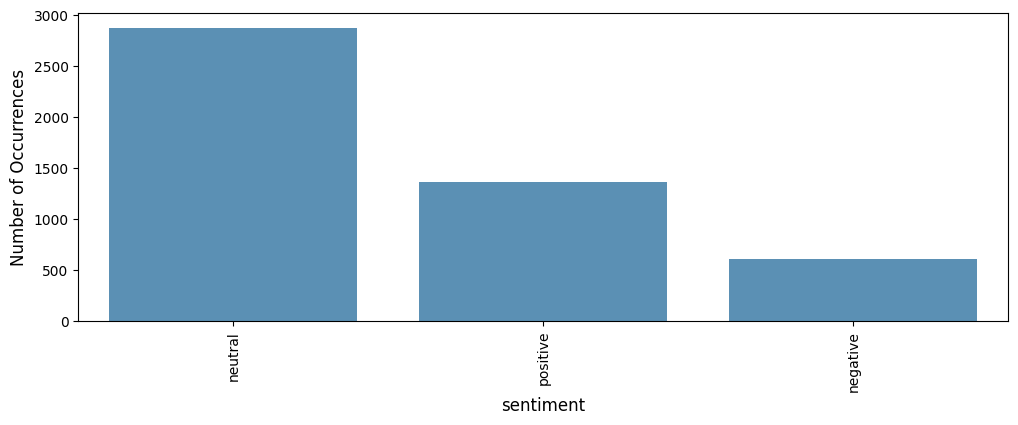

In [ ]:
cnt_pro=df["Sentiment"].value_counts()
plt.figure(figsize=(12,4))
sns.barplot(cnt_pro, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('sentiment', fontsize=12)
plt.xticks(rotation=90)
plt.show();

In [ ]:
sentiment  = {'positive': 0,'neutral': 1,'negative':2}

df.Sentiment = [sentiment[item] for item in df.Sentiment]
print(df)

      Sentiment                                          Statement
0             1  Technopolis plans to develop in stages an area...
1             2  The international electronic industry company ...
2             0  With the new production plant the company woul...
3             0  According to the company 's updated strategy f...
4             0  FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...
...         ...                                                ...
4840          2  LONDON MarketWatch -- Share prices ended lower...
4841          1  Rinkuskiai 's beer sales fell by 6.5 per cent ...
4842          2  Operating profit fell to EUR 35.4 mn from EUR ...
4843          2  Net sales of the Paper segment decreased to EU...
4844          2  Sales in Finland decreased by 10.5 % in Januar...

[4845 rows x 2 columns]


#Split and text cleaning#

In [ ]:
from bs4 import BeautifulSoup
def Cleantext(text):
  text = BeautifulSoup(text, "lxml").text
  text = re.sub(r'\|\|\|', r' ', text)
  text = re.sub(r'http\S+', r'<URL>', text)
  text = text.lower()
  text = text.replace('x', '')
  return text

In [ ]:
#train and test split
df['Statement'].apply(Cleantext)
train,test=train_test_split(df,test_size=0.00001,random_state=42);

<ipython-input-6-f8bdeb4882d6>:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "lxml").text


#Tokenize and tagging

In [ ]:
#tokenize
import nltk
nltk.download('punkt')
def tokenize_text(text):
  tokens=[]
  for sent in nltk.sent_tokenize(text):
    for word in nltk.word_tokenize(sent):
      if len(word)<=0:
        continue;
      tokens.append(word.lower())
  return tokens


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
#tagged train and test
train_tagged = train.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['Statement']), tags=[r.Sentiment]), axis=1)
test_tagged = test.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['Statement']), tags=[r.Sentiment]), axis=1)


In [ ]:
max_fatures = 500000

# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 50

#tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer = Tokenizer(num_words=max_fatures, split=' ', filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['Statement'].values)
X = tokenizer.texts_to_sequences(df['Statement'].values)
X = pad_sequences(X,maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (4845, 50)


#Training Doc2Vec

In [ ]:
d2v_model = Doc2Vec(dm=1, dm_mean=1,vector_size=20, window=8, min_count=1, workers=1, alpha=0.065, min_alpha=0.065)
d2v_model.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 4844/4844 [00:00<00:00, 1706898.14it/s]


In [ ]:
for epoch in range(30):
    d2v_model.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    d2v_model.alpha -= 0.002
    d2v_model.min_alpha = d2v_model.alpha

100%|██████████| 4844/4844 [00:00<00:00, 1604454.60it/s]


In [ ]:
print(d2v_model)

Doc2Vec<dm/m,d20,n5,w8,s0.001>


In [ ]:
len(d2v_model.wv.key_to_index)

11699

In [ ]:
embedding_matrix = np.zeros((len(d2v_model.wv.key_to_index)+ 1, 20))

for i, vec in enumerate(d2v_model.dv.vectors):
    while i in vec <= 1000:
          embedding_matrix[i]=vec
embedding_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

#Measuring distance between two vectors (related to cosine similarity)

In [ ]:
d2v_model.wv.most_similar(positive=['profit'], topn=10)

[('loss', 0.8727889657020569),
 ('profits', 0.8044567108154297),
 ('result', 0.7867183685302734),
 ('income', 0.7401697039604187),
 ('sales', 0.7333695292472839),
 ('4.9', 0.7308770418167114),
 ('wwd', 0.6771895885467529),
 ('116.6', 0.6710983514785767),
 ('margin', 0.6650224328041077),
 ('download', 0.6640092134475708)]

In [ ]:
'''
!pip install sklearn
from sklearn.manifold import TNSE
import matplotlib.pyplot as plt
%matplotlib inline
'''

'\n!pip install sklearn\nfrom sklearn.manifold import TNSE\nimport matplotlib.pyplot as plt\n%matplotlib inline\n'

In [ ]:
#Plot the words
'''
def tnse_plot(model):
  labels=[]
  tokens=[]

  for word in model.wv.key_to_index:
    labels.append(word)
    tokens.append(model[word])

  tnse_model=TNSE(perplexity=40, n_components=2, init='pca',max_iter=250, random_state=23)
  new_values=tnse_model.fit_transfrom(tokens)

  x=[]
  y=[]

  for val in new_values:
    x.append(val[0])
    y.append(val[1])

  plt.figure(figsize=(16, 16))
  for i in range(len(x)):
    plt.scatter(x[i],y[i])
    plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
  plt.show()
'''

"\ndef tnse_plot(model):\n  labels=[]\n  tokens=[]\n\n  for word in model.wv.key_to_index:\n    labels.append(word)\n    tokens.append(model[word])\n\n  tnse_model=TNSE(perplexity=40, n_components=2, init='pca',max_iter=250, random_state=23)\n  new_values=tnse_model.fit_transfrom(tokens)\n\n  x=[]\n  y=[]\n\n  for val in new_values:\n    x.append(val[0])\n    y.append(val[1])\n\n  plt.figure(figsize=(16, 16))\n  for i in range(len(x)):\n    plt.scatter(x[i],y[i])\n    plt.annotate(labels[i],\n                     xy=(x[i], y[i]),\n                     xytext=(5, 2),\n                     textcoords='offset points',\n                     ha='right',\n                     va='bottom')\n  plt.show()\n"

#LSTM Model

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding

model=Sequential()

model.add(Embedding(len(d2v_model.wv.key_to_index)+1,20,input_length=X.shape[1],weights=[embedding_matrix],trainable=True))
model.add(LSTM(50,return_sequences=False))
model.add(Dense(3,activation="softmax"))

model.summary()
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=['acc'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 20)            234000    
                                                                 
 lstm (LSTM)                 (None, 50)                14200     
                                                                 
 dense (Dense)               (None, 3)                 153       
                                                                 
Total params: 248353 (970.13 KB)
Trainable params: 248353 (970.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


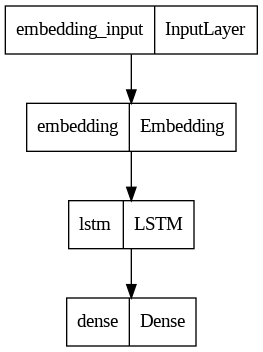

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

In [ ]:
Y = pd.get_dummies(df['Sentiment']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.15, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(4118, 50) (4118, 3)
(727, 50) (727, 3)


In [ ]:
batch_size = 32
history=model.fit(X_train, Y_train, epochs =50, batch_size=batch_size, verbose = 2)

Epoch 1/50
129/129 - 16s - loss: 0.5470 - acc: 0.6013 - 16s/epoch - 123ms/step
Epoch 2/50
129/129 - 5s - loss: 0.4039 - acc: 0.7122 - 5s/epoch - 36ms/step
Epoch 3/50
129/129 - 5s - loss: 0.2940 - acc: 0.7941 - 5s/epoch - 35ms/step
Epoch 4/50
129/129 - 4s - loss: 0.2256 - acc: 0.8390 - 4s/epoch - 31ms/step
Epoch 5/50
129/129 - 5s - loss: 0.1537 - acc: 0.9121 - 5s/epoch - 36ms/step
Epoch 6/50
129/129 - 5s - loss: 0.1059 - acc: 0.9492 - 5s/epoch - 39ms/step
Epoch 7/50
129/129 - 4s - loss: 0.0686 - acc: 0.9692 - 4s/epoch - 31ms/step
Epoch 8/50
129/129 - 4s - loss: 0.0470 - acc: 0.9801 - 4s/epoch - 31ms/step
Epoch 9/50
129/129 - 8s - loss: 0.0446 - acc: 0.9806 - 8s/epoch - 64ms/step
Epoch 10/50
129/129 - 7s - loss: 0.0282 - acc: 0.9869 - 7s/epoch - 56ms/step
Epoch 11/50
129/129 - 6s - loss: 0.0267 - acc: 0.9898 - 6s/epoch - 44ms/step
Epoch 12/50
129/129 - 4s - loss: 0.0302 - acc: 0.9876 - 4s/epoch - 30ms/step
Epoch 13/50
129/129 - 4s - loss: 0.0212 - acc: 0.9915 - 4s/epoch - 30ms/step
Epoch

In [ ]:
_, train_acc = model.evaluate(X_train, Y_train, verbose=2)
_, test_acc = model.evaluate(X_test, Y_test, verbose=2)
print('Train: %.3f, Test: %.4f' % (train_acc, test_acc))

129/129 - 2s - loss: 0.0011 - acc: 0.9995 - 2s/epoch - 19ms/step
23/23 - 0s - loss: 1.3206 - acc: 0.6905 - 234ms/epoch - 10ms/step
Train: 1.000, Test: 0.6905


In [ ]:
yhat_probs = model.predict(X_test)
print(yhat_probs)
# predict crisp classes for test set
yhat_classes = np.argmax(yhat_probs,axis=1)
print(yhat_classes)

23/23 [==============================] - 1s 10ms/step
[[8.7674074e-08 9.9999982e-01 2.4704008e-08]
 [9.9999994e-01 4.4721387e-09 7.0865300e-09]
 [3.9079751e-07 9.9999923e-01 3.1828114e-07]
 ...
 [1.0000000e+00 1.0358919e-08 6.6102501e-09]
 [5.3003646e-07 9.9999928e-01 2.2797586e-07]
 [9.9994826e-01 5.0762355e-05 9.0075912e-07]]
[1 0 1 0 1 1 1 1 1 1 1 1 1 2 1 1 1 1 0 1 1 1 0 0 1 0 1 1 0 0 1 1 1 2 1 1 2
 0 1 1 0 1 2 0 0 1 1 1 0 1 2 1 2 2 1 0 1 1 0 1 0 0 0 0 1 1 1 1 1 0 1 0 0 1
 0 1 1 1 1 0 1 2 0 1 0 0 1 0 1 0 2 1 1 2 1 1 0 1 1 1 2 1 1 2 1 1 1 1 2 1 1
 1 2 1 1 0 0 0 0 0 0 0 0 1 1 1 1 0 1 1 1 0 2 1 0 1 0 1 1 1 1 1 1 1 1 1 2 1
 0 1 1 0 1 0 1 0 0 1 2 2 0 0 1 0 1 0 1 2 1 0 1 0 0 1 0 2 0 0 1 0 0 0 0 1 1
 2 1 0 1 1 1 0 0 1 2 0 1 1 1 1 1 1 1 1 1 0 1 1 0 1 0 1 1 1 0 1 1 2 1 0 0 1
 1 2 1 1 1 0 1 1 1 0 1 1 2 0 1 1 1 1 1 1 1 0 0 1 1 1 0 1 0 1 0 0 1 0 1 1 1
 1 1 0 1 0 2 2 0 1 1 1 1 1 2 1 1 1 1 0 0 0 1 0 1 1 1 1 1 1 0 1 0 2 0 1 2 1
 1 1 0 1 0 1 1 1 1 2 1 0 1 0 1 2 0 1 1 1 1 1 1 1 1 1 0 1 0 1 1 0 1 1 1

In [ ]:
rounded_labels=np.argmax(Y_test, axis=1)
rounded_labels

array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 2, 1, 0, 1, 0, 0, 2, 2, 1,
       0, 0, 1, 0, 1, 0, 0, 2, 1, 1, 0, 2, 1, 0, 2, 0, 1, 1, 0, 1, 2, 1,
       0, 1, 1, 1, 0, 0, 2, 1, 0, 2, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 2, 1,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 2, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 2, 2, 1, 0, 1, 1, 0, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1,
       1, 0, 2, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 2, 0,
       1, 1, 0, 1, 0, 2, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 2, 0, 0, 1, 0, 1, 0, 1, 2, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 2, 1, 2, 1, 2, 1, 1, 0, 0, 1, 0, 2, 1,
       2, 0, 1, 1, 0, 2, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 1,
       0, 1, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 0, 1, 2, 0, 1, 0, 1, 1, 1, 1,
       1, 2, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       2, 1, 2, 1, 1, 0, 1, 1, 2, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1,
       1, 1, 2, 1, 0, 1, 0, 2, 2, 1, 1, 1, 0, 1, 0,

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(rounded_labels, yhat_classes)
cm

array([[127,  83,   5],
       [ 79, 329,  18],
       [ 16,  24,  46]])

#Validation

In [ ]:
validation_size=610
X_test = X_test[:-validation_size]
Y_test = Y_test[:-validation_size]
score,acc = model.evaluate(X_test, Y_test, verbose = 1, batch_size = batch_size)

print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

4/4 [==============================] - 0s 17ms/step - loss: 1.2361 - acc: 0.7521
score: 1.24
acc: 0.75


In [ ]:
#Save Model
model.save('Mymodel.keras')

#Test with new and different data set aside from the data to build the model.

note : sentiment = {'positive': 0,'neutral': 1,'negative':2}

In [ ]:
message = ['Congratulations! you have won a $1,000 Walmart gift card']
seq = tokenizer.texts_to_sequences(message)

padded = pad_sequences(seq, maxlen=X.shape[1], dtype='int32', value=0)

pred = model.predict(padded)

labels = ['0','1','2']
print(pred, labels[np.argmax(pred)])

1/1 [==============================] - 0s 39ms/step
[[0.03319052 0.6288635  0.33794597]] 1


In [ ]:
message = ['such massive asteroid hit will certainly create new business opportunities']
seq = tokenizer.texts_to_sequences(message)

padded = pad_sequences(seq, maxlen=X.shape[1], dtype='int32', value=0)

pred = model.predict(padded)

labels = ['0','1','2']
print(pred, labels[np.argmax(pred)])

1/1 [==============================] - 0s 24ms/step
[[0.45322478 0.00782316 0.538952  ]] 2


In [ ]:
message = ['so does anyone else not open Snapchat anymore ? or is it just me ... ugh this so sad.']
seq = tokenizer.texts_to_sequences(message)

padded = pad_sequences(seq, maxlen=X.shape[1], dtype='int32', value=0)

pred = model.predict(padded)

labels = ['0','1','2']
print(pred, labels[np.argmax(pred)])

1/1 [==============================] - 0s 27ms/step
[[1.4740033e-10 1.0000000e+00 1.2878180e-10]] 1
